# Simulation of NMR Shaped Pulses: NumPy vs Fortran
*This notebook first appeared as a [blog](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/) post on [themodernscientist](http://themodernscientist.com).  
License: [BSD](http://opensource.org/licenses/BSD-3-Clause) (C) 2013, Michelle L. Gill. Feel free to use, distribute, and modify with the above attribution.*

This IPython notebook demonstrates how to simulate one of my favorite NMR shaped pulses, the [Reburp](http://www.sciencedirect.com/science/article/pii/002223649190034Q) pulse. This is a refocusing pulse, meaning it rotates magnetization 180º regardless of initial state of the magnetization. The Reburp pulse has excellent bandwidth selectivity because its excitation profile closely approximates that of a [top hat function](http://en.wikipedia.org/wiki/Top-hat_filter), which will be evident when the calculated excitation profile is plotted.

This simulation requires installation of a fortran compiler, the [f2py package](http://www.f2py.com) for converting fortran code into Python modules, and the `f2pymagic` [extension](https://github.com/ipython/ipython/pull/2674) for compiling the fortran code within this IPython notebook. I installed `gfortran` and `f2py` via MacPorts. The `f2pymagic` extension was installed in the IPython profile used for notebooks by placing the file in the `~/.ipython/profile_notebook/extensions` directory, where `profile_notebook` should be changed to the name of the notebook profile. The `extensions` directory may need to be created. Additional required packages include NumPy, Matplotlib, and, optionally, [SymPy](http://docs.sympy.org/0.7.0/index.html).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as spy
%matplotlib inline

The following command loads the `f2pymagic` extension:

In [5]:
%load_ext f2pymagic

## Spectrometer Implementation and Simulation of Shaped Pulses
Due to the nature of spectrometer hardware, a shaped pulse is implemented as a large number ($N$ or `n_pulse` as used here) of rectangular pulses of length $\Delta t$, where the total pulse length, $\tau_{p}$, is equal to $N \Delta t$. The net rotation of the entire pulse is the product of the following five rotations about the *y*- and *z*-axes performed for each successive period $\Delta t$ at each relative frequency:  

$R(\tau_{p}) = \prod^{N}_{i=1} R_{z}(\phi_{i}) \space R_{y}(\theta_{i}) \space R_{z}(\alpha_{i}) \space R_{y}(-\theta_{i}) \space R_{z}(-\phi_{i})$

where $\phi_{i}$, $\theta_{i}$, and $\alpha_{i}$ are the respective phase, tilt angle and effective rotation for each time $\Delta t$ in the pulse. This calculation and its derivation are described in equation 3.107 and surrounding text of [Protein NMR Spectroscopy: Principles and Practice, Second Edition](http://www.palmer.hs.columbia.edu/protein_nmr_spectroscopy/index.html). The rotation matrices are:  

$$\begin{eqnarray*}
R_{x}(\beta) = \left[ \begin{array}{ccc} 1 & 0 & 0 \\ 0 & cos(\beta) & -sin(\beta) \\ 0 & sin(\beta) & cos(\beta) \end{array} \right]\\
R_{y}(\beta) = \left[ \begin{array}{ccc} cos(\beta) & 0 & sin(\beta) \\ 0 & 1 & 0 \\ -sin(\beta) & 0 & cos(\beta) \end{array} \right]\\
R_{z}(\beta) = \left[ \begin{array}{ccc} cos(\beta) & -sin(\beta) & 0 \\ sin(\beta) & cos(\beta) & 0 \\ 0 & 0 & 1 \end{array} \right]\\
\end{eqnarray*}$$

where $\beta$ is an arbitrary angle, as in equation 1.35 of the same text. ($R_{x}$ is shown only for completeness and is not used in the above calculation.)

Note that, while the simulation in this notebook does consider the effects of resonance offset, it does not consider evolution during the pulse itself. Furthermore, this method will not work as implemented to simulate adiabatic pulses.

## Setup Pulse and Frequency Range Properties
Enter the length of the pulse (in $\mu$s), the minimum and maximum offset of the frequency range (both in hertz), the number of steps in the frequency range, and the input magnetization ('Mx', 'My', 'Mz').

In [6]:
pulseLength = 1000. # in microseconds
offset = [-5000., 5000.] # in hertz
n_freq = 500
inputMagnetization = 'Mz' # 'Mx', 'My', or 'Mz'

Calculate the frequency range and spacing for each of these points.

In [7]:
deltaomega = np.abs(offset[1]-offset[0])/n_freq
relativeomega = np.arange(np.min(offset), np.max(offset), deltaomega)

## Input Shaped Pulse Amplitude and Intensity
Two options for determining the amplitude and intensity of a shaped pulse are presented. The first (used in this demonstration) calculates the necessary values for a Reburp pulse. The second option will read a Reburp pulse file (or any other shaped pulse file) from a Bruker instrument if the correct path to the file is given.
### *Alternative 1:* Calculate the Shaped Pulse From a Fourier Series
The Reburp pulse is relatively easy to calculate--the pulse is the cosine portion of a Fourier series and the coefficients for this series are published in the original [manuscript](http://www.sciencedirect.com/science/article/pii/002223649190034Q) describing the "burp" family of pulses.

In [8]:
n_pulse = 1000 # number of points in the pulse, set by user
totalRotation = 180. # in degrees, set by user

fourierCoeffA = np.array([0.49, -1.02, 1.11, -1.57, 0.83, 
                          -0.42, 0.26, -0.16, 0.10, -0.07, 
                          0.04, -0.03, 0.01, -0.02, 0.0, -0.01])
x = np.linspace(1,n_pulse,n_pulse)/n_pulse*2.*np.pi
nCosCoef = np.arange(1, len(fourierCoeffA))
cosMat = np.cos(nCosCoef[np.newaxis,:]*x[:,np.newaxis])
cosMat = np.append(np.ones((n_pulse, 1)), cosMat,axis=1)*fourierCoeffA
sumMat = np.sum(cosMat, axis=1)

This makes the data look just like the values from Bruker's shaped pulse file. The first column in `puleShapeArray` is the magnitude of the intensity. The second column is phase, which in this case is `0` when intensity is positive, and `180` when it's negative (recall that $\cos(\pi) = -1$).

In [9]:
pulseShapeArray = np.zeros((n_pulse, 2))
pulseShapeArray[:,0] = np.abs(sumMat)
pulseShapeArray[sumMat<0,1] = 180.

### *Alternative 2:* Read a Bruker Shaped Pulse File
Reading a Bruker shaped pulse file requires entering the path to the file. For most versions of TopSpin, the file resides in a path similar to the one below. This file can be copied onto a local computer for reading by this notebook.

In [7]:
pulseFile = '/opt/topspin/exp/stan/nmr/lists/wave/Reburp.1000' # path to shaped pulse file, set by user

Read in the data from the pulse file and extract necessary information.

In [9]:
import re
from StringIO import StringIO
pulseString = open(pulseFile, 'r').read()
pulseShapeArray = np.loadtxt(StringIO(pulseString), comments='#', delimiter=', ')
n_pulse = pulseShapeArray.shape[0]
totalRotation = np.float(re.search("""SHAPE_TOTROT=\s?(.*)""", pulseString).group(1))
# Option to read the scaling factor from the file instead of calculating it below
# scalingFactor = np.float(re.search("""SHAPE_INTEGFAC=\s?(.*)""",pulseString).group(1))

## Visualizing the Shaped Pulse 
Normalize the magnitude of the pulse to `1` and convert the phase to radians.

In [10]:
pulseShapeInten = pulseShapeArray[:,0] / np.max(np.abs(pulseShapeArray[:,0]))
pulseShapePhase = pulseShapeArray[:,1] * np.pi/180

The magnitude and phase of the pulse can be seen by plotting.

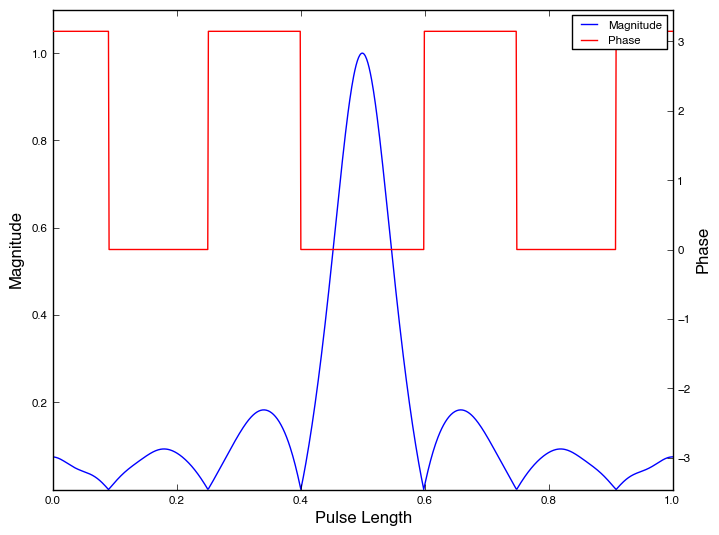

In [11]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax1 = plt.axes()
ax2 = ax1.twinx()
l1, = ax1.plot(np.linspace(0, 1, n_pulse), pulseShapeInten, 'b-', label='Magnitude')
l2, = ax2.plot(np.linspace(0, 1, n_pulse), pulseShapePhase, 'r-', label='Phase')
ax1.set_ylim((1.1*np.min(pulseShapeInten), 1.1*np.max(pulseShapeInten)))
ax2.set_ylim((-1.1*np.pi,np.pi*1.1))
ax1.set_xlabel('Pulse Length')
ax1.set_ylabel('Magnitude')
ax2.set_ylabel('Phase')
ax2.legend([l1, l2], [l1.get_label(), l2.get_label()])

The *x*- and *y*-components of the pulse are the products of the intensity and the complex phase.

In [12]:
xPulseShape = pulseShapeInten * np.cos(pulseShapePhase)
yPulseShape = pulseShapeInten * np.sin(pulseShapePhase)

These can also be plotted. Note that the amplitude is negated everywhere the phase was 180º and the value of the phase is now zero everywhere.

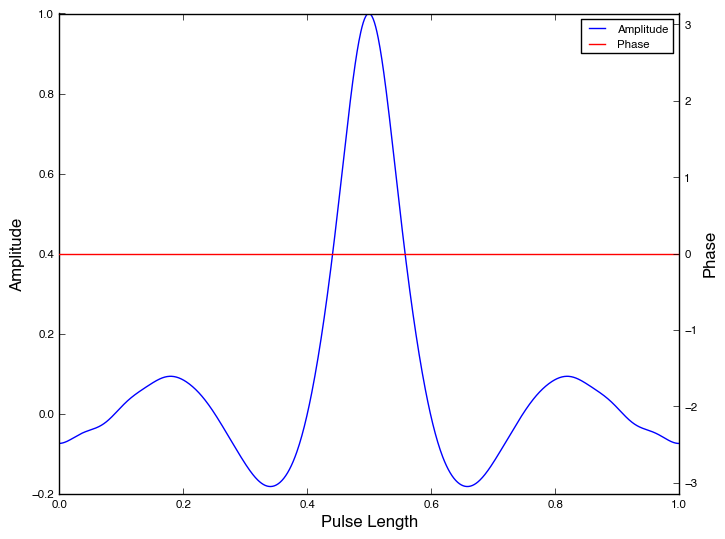

In [13]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax3 = plt.axes()
ax4 = ax3.twinx()
l1, = ax3.plot(np.linspace(0, 1, n_pulse), xPulseShape, 'b-', label='Amplitude')
l2, = ax4.plot(np.linspace(0, 1, n_pulse), yPulseShape, 'r-', label='Phase')
ax4.set_ylim((-np.pi, np.pi))
ax3.set_xlabel('Pulse Length')
ax3.set_ylabel('Amplitude')
ax4.set_ylabel('Phase')
ax4.legend([l1, l2],[l1.get_label(), l2.get_label()])

The shaped pulse has a bandwidth just like a rectangular (hard) pulse, except that this bandwidth is scaled by the intensity.

In [14]:
scalingFactor = np.sum(xPulseShape)/n_pulse
gammaB1max = 1./(pulseLength * 360./totalRotation)/scalingFactor * 1e6
nu1maxdt = 2*np.pi*1e-6*gammaB1max*pulseLength/n_pulse

Setup the starting magnization on the *x*-, *y*-, or *z*-axis. The default is *z* magnetization if nothing is set or an invalid choice is made.

In [15]:
inputVector = np.array([[0],[0],[1]])
inputMagnetizationDict = {'mx':np.array([[1],[0],[0]]), 'my':np.array([[0],[1],[0]]), 'mz':np.array([[0],[0],[1]]) }
if inputMagnetization.lower() in inputMagnetizationDict.keys():
    inputVector = inputMagnetizationDict[inputMagnetization.lower()]
vectorComponent = inputVector.argmax()

## Calculating the Propagator: NumPy vs Fortran Functions Using F2PY Magic
This exercise was started as demonstration for incorporating f2pymagic in an IPython notebook to utilize the great increase in speed it can provide over Python. However, spending additional time optimizing the NumPy function resulted in a considerable speed increase on its own. Since the web-centric nature of IPython notebooks allows technical information to be visualized and shared so easily, the original (slow) function has been included for the sake of demonstrating what I've learned.
### *Alternative 1:* A Slow NumPy Function
This was a first attempt at writing a function to calculate the effect of a shaped pulse on a frequency range. This function is written exactly how I think about the problem mathematically: as a series of nested loops and rotations.

In [16]:
def pulseprop_py_slow(relativeomega, pulseShapeInten, pulseShapePhase, 
                      gammaB1max, nu1maxdt, inputVector, n_pulse, n_freq):
    # Functions for the y and z-rotations and the the function for a generic rotation
    yrotation = lambda beta: np.array([[np.cos(beta), 0, np.sin(beta)], 
                                       [0, 1, 0], 
                                       [-np.sin(beta), 0, np.cos(beta)]])
    zrotation = lambda beta: np.array([[np.cos(beta), -np.sin(beta), 0], 
                                       [np.sin(beta), np.cos(beta), 0], 
                                       [0, 0, 1]])
    grotation = lambda alpha, theta, phi: np.dot(zrotation(phi), np.dot(yrotation(theta), np.dot(zrotation(alpha), 
                                          np.dot(yrotation(-theta),zrotation(-phi)))))
    
    
    xyzdata = np.zeros((3,len(relativeomega)))
    phi = pulseShapePhase
    
    # Loop through the entire frequency range calculating the rotation matrix (r) at each frequency
    for ind in range(len(relativeomega)):
    
        theta = np.arctan2(pulseShapeInten, relativeomega[ind]/gammaB1max)
        alpha = nu1maxdt * np.sqrt(pulseShapeInten**2+(relativeomega[ind]/gammaB1max)**2)
        
        prop = np.eye(3)
        # The rotation matrix is a recursive loop through each step of the shaped pulse
        for pulseindex in range(n_pulse):
            r = grotation(alpha[pulseindex],theta[pulseindex],phi[pulseindex])
            prop = np.dot(r,prop)
        xyzdata[:,ind] = np.squeeze(np.dot(prop,inputVector))
        
    return xyzdata

In [17]:
%timeit pulseprop_py_slow(relativeomega, pulseShapeInten, 
                          pulseShapePhase, gammaB1max, 
                          nu1maxdt, inputVector, n_pulse, n_freq)

1 loops, best of 3: 1min 26s per loop


As the name implies, this function is pretty slow. One could use python's [profiler](http://docs.python.org/2/library/profile.html) to determine where the bottlenecks are, but it's also easy to guess that the culprits are the pair of nested `for` loops and, on the inside of these loops, a call to `grotation`, the generalized rotation function, that itself calls two functions, `yrotation` and `zrotation`, two times each. To speed up the calculation, we should eliminate as much of the looping and function calls as possible.
### *Alternative 2:* The Improved NumPy Function
The looping can be reduced by improving the vectorization of the function so that it operates on matrices instead of looping through each point of the pulse and frequency range. The calls to the rotation functions can be eliminated by calculating each of the nine elements of the matrix resulting from `grotation`. This can even be done symbolically using SymPy.

In [18]:
a,b,t,p = spy.symbols('a,b,t,p')
zr = lambda b: spy.Matrix([[spy.cos(b), -spy.sin(b), 0], [spy.sin(b), spy.cos(b), 0], [0, 0, 1]])
xr = lambda b: spy.Matrix([[1, 0, 0], [0, spy.cos(b), -spy.sin(b)], [0, spy.sin(b), spy.cos(b)]])
yr = lambda b: spy.Matrix([[spy.cos(b), 0, spy.sin(b)], [0, 1, 0], [-spy.sin(b), 0, spy.cos(b)]])
gr = lambda a, t, p : zr(p)*yr(t)*zr(a)*yr(-t)*zr(-p)

This function can be evaluated numerically, if desired.

In [19]:
gr(np.pi/2, 0, np.pi)

[6.12323399573676e-17,                 -1.0, 0]
[                 1.0, 6.12323399573676e-17, 0]
[                   0,                    0, 1]

Unfortunately, it can't be evalued numerically with NumPy's `ndarrays` because it hasn't been vectorized.

In [20]:
an = np.random.random((4,5))
tn = np.random.random((4,5))
pn = np.random.random((4,5))
try:
    gr(an,tn,pn)
except:
    print("Sad trombone. The SymPy function doesn't work with NumPy arrays.")

Sad trombone. The SymPy function doesn't work with NumPy arrays.


None of my attempts at automatically vectorizing this function were successful.[1](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/#fn:sympytheano) Since the matrix is only 3x3, it is not difficult to calculate each of the nine matrix elements. Their symbolic values can be determined by printing each element of the SymPy matrix. Note the use of SymPy's `simplify` function for algebraic simplification.

In [21]:
r = gr(a,t,p)
for row in range(3):
    for col in range(3):
        print('r[%d,%d] = %s' % (row,col,spy.simplify(r[row,col])))

r[0,0] = sin(p)**2*cos(a) + sin(t)**2*cos(p)**2 + cos(a)*cos(p)**2*cos(t)**2
r[0,1] = -sin(a)*cos(t) - sin(p)*sin(t)**2*cos(a)*cos(p) + sin(p)*sin(t)**2*cos(p)
r[0,2] = (sin(a)*sin(p) - cos(a)*cos(p)*cos(t) + cos(p)*cos(t))*sin(t)
r[1,0] = sin(a)*cos(t) - sin(p)*sin(t)**2*cos(a)*cos(p) + sin(p)*sin(t)**2*cos(p)
r[1,1] = -sin(p)**2*sin(t)**2*cos(a) + sin(p)**2*sin(t)**2 + cos(a)
r[1,2] = (-sin(a)*cos(p) - sin(p)*cos(a)*cos(t) + sin(p)*cos(t))*sin(t)
r[2,0] = -((cos(a) - 1)*cos(p)*cos(t) + sin(a)*sin(p))*sin(t)
r[2,1] = (-(cos(a) - 1)*sin(p)*cos(t) + sin(a)*cos(p))*sin(t)
r[2,2] = sin(t)**2*cos(a) + cos(t)**2


Using the elements of the rotation matrix and a few other vectorization tricks, I improved the function. In my opinion, the individual calculation of matrix elements makes this function more difficult to read, but readability wasn't the primary goal of this exercise.

In [22]:
def pulseprop_py_fast(relativeomega, pulseShapeInten, pulseShapePhase, 
                      gammaB1max, nu1maxdt, vectorComponent, n_pulse, n_freq):
    # Use broadcasting to create 2D arrays (n_freq x n_rows) for each of the angles
    phi = np.tile(pulseShapePhase[np.newaxis,:],(n_freq,1))
    theta = np.arctan2(pulseShapeInten[np.newaxis,:], relativeomega[:,np.newaxis]/gammaB1max)
    alpha = nu1maxdt * np.sqrt(pulseShapeInten[np.newaxis,:]**2 + (relativeomega[:,np.newaxis]/gammaB1max)**2)
    
    # Then calculate their cosine/sine functions
    cosp = np.cos(phi)
    sinp = np.sin(phi)
    cosa = np.cos(alpha)
    sina = np.sin(alpha)
    cost = np.cos(theta)
    sint = np.sin(theta)
    
    # Calculate each element of the rotation matrix
    r = np.empty((3,3,n_freq,n_pulse))
    r[0,0] = sinp**2*cosa + sint**2*cosp**2 + cosa*cosp**2*cost**2
    r[0,1] = -sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
    r[0,2] = (sina*sinp - cosa*cosp*cost + cosp*cost)*sint
    r[1,0] = sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
    r[1,1] = -sinp**2*sint**2*cosa + sinp**2*sint**2 + cosa
    r[1,2] = (-sina*cosp - sinp*cosa*cost + sinp*cost)*sint
    r[2,0] = -((cosa - 1)*cosp*cost + sina*sinp)*sint
    r[2,1] = (-(cosa - 1)*sinp*cost + sina*cosp)*sint
    r[2,2] = sint**2*cosa + cost**2
    
    # Calculate the propagator for the pulse--this is a recursive multiplication so I don't
    # know of a way to vectorize this loop. If someone knows, please share in the comments
    prop = np.tile(np.eye(3)[:,:,np.newaxis],(1,1,n_freq))
    for pulseindex in range(n_pulse):
        r_s = np.squeeze(r[:,:,:,pulseindex])
        
        # Must create immutable copies of the views for multiplication
        prop00 = prop[0,0].copy()
        prop01 = prop[0,1].copy()
        prop02 = prop[0,2].copy()
        prop10 = prop[1,0].copy()
        prop11 = prop[1,1].copy()
        prop12 = prop[1,2].copy()
        prop20 = prop[2,0].copy()
        prop21 = prop[2,1].copy()
        prop22 = prop[2,2].copy()
        r00 = r_s[0,0].copy()
        r01 = r_s[0,1].copy()
        r02 = r_s[0,2].copy()
        r10 = r_s[1,0].copy()
        r11 = r_s[1,1].copy()
        r12 = r_s[1,2].copy()
        r20 = r_s[2,0].copy()
        r21 = r_s[2,1].copy()
        r22 = r_s[2,2].copy()
        
        prop[0,0] = r00*prop00 + r01*prop10 + r02*prop20
        prop[0,1] = r00*prop01 + r01*prop11 + r02*prop21
        prop[0,2] = r00*prop02 + r01*prop12 + r02*prop22
        
        prop[1,0] = r10*prop00 + r11*prop10 + r12*prop20
        prop[1,1] = r10*prop01 + r11*prop11 + r12*prop21
        prop[1,2] = r10*prop02 + r11*prop12 + r12*prop22
        
        prop[2,0] = r20*prop00 + r21*prop10 + r22*prop20
        prop[2,1] = r20*prop01 + r21*prop11 + r22*prop21
        prop[2,2] = r20*prop02 + r21*prop12 + r22*prop22

        # This is a looped alternative to the above, but it is slower
        # for i in range(3):
        #     for j in range(3):
        #         for k in range(3):
        #             prop[i,j] += r_tmp[i,k]*prop[k,j]
        
    # Since the starting magnetization is x, y, or z, just pick the right index
    # rather than multiplying
    xyzdata = np.squeeze(prop[:,vectorComponent])
    
    return xyzdata

As expected, this subroutine runs much more quickly. (And I'd love to hear from anyone who can improve the speed of this function even more.)

In [23]:
%timeit pulseprop_py_fast(relativeomega, pulseShapeInten, 
                          pulseShapePhase, gammaB1max, nu1maxdt, 
                          vectorComponent, n_pulse, n_freq)

1 loops, best of 3: 428 ms per loop


In [31]:
print("Relative speed up of %.0f times for the vectorized NumPy function." % (86./0.428))

Relative speed up of 201 times for the vectorized NumPy function.


### *Alternative 3:* The Fortran Function Using F2PY Magic
Before trying to optimize the NumPy version, I wrote a fortran version to calculate the propagator for the pulse. I was able to further improve the speed of the fortran function using some of the techniques learned from the NumPy function optimization. This improved version is presented below. My fortran skills haven't been dusted off since my freshman year of college, so I'm certain there are ways to further improve this function.

In [26]:
%%f2py
! -*- f90 -*-
subroutine propcalc(alpha, theta, phi, n_freq, n_pulse, prop)

integer, intent(in) :: n_freq, n_pulse
real, dimension(n_freq, n_pulse), intent(in) :: alpha(n_freq, n_pulse), theta(n_freq, n_pulse), phi(n_freq, n_pulse)

real, dimension(n_freq, n_pulse) :: cosp(n_freq, n_pulse), sinp(n_freq, n_pulse), cosa(n_freq, n_pulse)
real, dimension(n_freq, n_pulse) :: sina(n_freq, n_pulse), cost(n_freq, n_pulse), sint(n_freq, n_pulse)
real, dimension(3, 3, n_freq, n_pulse) :: r(3, 3, n_freq, n_pulse)
real, dimension(n_freq) :: r11(n_freq), r12(n_freq), r13(n_freq)
real, dimension(n_freq) :: r21(n_freq), r22(n_freq), r23(n_freq)
real, dimension(n_freq) :: r31(n_freq), r32(n_freq), r33(n_freq)
real, dimension(n_freq) :: p11(n_freq), p12(n_freq), p13(n_freq)
real, dimension(n_freq) :: p21(n_freq), p22(n_freq), p23(n_freq)
real, dimension(n_freq) :: p31(n_freq), p32(n_freq), P33(n_freq)
        
real, dimension(3, 3, n_freq), intent(out) :: prop(3, 3, n_freq)
!   The following line is required so the function can return a variable to python:
!   f2py real, dimension(3, 3, n_freq), intent(out) :: prop(3, 3, n_freq)

cosp = cos(phi)
sinp = sin(phi)
cosa = cos(alpha)
sina = sin(alpha)
cost = cos(theta)
sint = sin(theta)

r(1,1,:,:) = sinp**2*cosa + sint**2*cosp**2 + cosa*cosp**2*cost**2
r(1,2,:,:) = -sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
r(1,3,:,:) = (sina*sinp - cosa*cosp*cost + cosp*cost)*sint
r(2,1,:,:) = sina*cost - sinp*sint**2*cosa*cosp + sinp*sint**2*cosp
r(2,2,:,:) = -sinp**2*sint**2*cosa + sinp**2*sint**2 + cosa
r(2,3,:,:) = (-sina*cosp - sinp*cosa*cost + sinp*cost)*sint
r(3,1,:,:) = -((cosa - 1)*cosp*cost + sina*sinp)*sint
r(3,2,:,:) = (-(cosa - 1)*sinp*cost + sina*cosp)*sint
r(3,3,:,:) = sint**2*cosa + cost**2

prop = spread(reshape([1,0,0,0,1,0,0,0,1],[3,3]),3,n_freq)

do i=1,n_pulse
!   Is there a way to do this without reshaping?
    r11 = reshape(r(1,1,:,i), [n_freq])
    r12 = reshape(r(1,2,:,i), [n_freq])
    r13 = reshape(r(1,3,:,i), [n_freq])
    r21 = reshape(r(2,1,:,i), [n_freq])
    r22 = reshape(r(2,2,:,i), [n_freq])
    r23 = reshape(r(2,3,:,i), [n_freq])
    r31 = reshape(r(3,1,:,i), [n_freq])
    r32 = reshape(r(3,2,:,i), [n_freq])
    r33 = reshape(r(3,3,:,i), [n_freq])
    
    p11 = reshape(prop(1,1,:), [n_freq])
    p12 = reshape(prop(1,2,:), [n_freq])
    p13 = reshape(prop(1,3,:), [n_freq])
    p21 = reshape(prop(2,1,:), [n_freq])
    p22 = reshape(prop(2,2,:), [n_freq])
    p23 = reshape(prop(2,3,:), [n_freq])
    p31 = reshape(prop(3,1,:), [n_freq])
    p32 = reshape(prop(3,2,:), [n_freq])
    p33 = reshape(prop(3,3,:), [n_freq])
    
    prop(1,1,:) = r11*p11 + r12*p21 + r13*p31
    prop(1,2,:) = r11*p12 + r12*p22 + r13*p32
    prop(1,3,:) = r11*p13 + r12*p23 + r13*p33
    prop(2,1,:) = r21*p11 + r22*p21 + r23*p31
    prop(2,2,:) = r21*p12 + r22*p22 + r23*p32
    prop(2,3,:) = r21*p13 + r22*p23 + r23*p33
    prop(3,1,:) = r31*p11 + r32*p21 + r33*p31
    prop(3,2,:) = r31*p12 + r32*p22 + r33*p32
    prop(3,3,:) = r31*p13 + r32*p23 + r33*p33

end do

return
end

propcalc is ready for use

In [27]:
def pulseprop_fort(relativeomega, pulseShapeInten, pulseShapePhase, 
                   gammaB1max, nu1maxdt, vectorComponent, n_pulse, n_freq):
    # Setup the angles using broadcasting as before
    phi = np.tile(pulseShapePhase[np.newaxis,:],(n_freq,1))
    theta = np.arctan2(pulseShapeInten[np.newaxis,:], relativeomega[:,np.newaxis]/gammaB1max)
    alpha = nu1maxdt * np.sqrt(pulseShapeInten[np.newaxis,:]**2 + (relativeomega[:,np.newaxis]/gammaB1max)**2)
    
    # Calculate the propagator and select the appropriate magnetization
    prop = propcalc(alpha, theta, phi, n_freq, n_pulse)
    xyzdata = np.squeeze(prop[:,vectorComponent])
    
    return xyzdata

In [28]:
%timeit pulseprop_fort(relativeomega, pulseShapeInten, 
                       pulseShapePhase, gammaB1max, nu1maxdt, vectorComponent, n_pulse, n_freq)

10 loops, best of 3: 140 ms per loop


In [32]:
print "Relative speed up of %.0f times for fortran over the slow numpy function." % (86./0.140)
print "Relative speed up of %.0f times for fortran over the vectorized numpy function." % (0.428/0.140)

Relative speed up of 614 times for fortran over the slow numpy function.
Relative speed up of 3 times for fortran over the vectorized numpy function.


As expected, this function is much faster than the original NumPy version. In this case, the speed increase over the improved NumPy version is rather modest.[2](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/#fn:numbacython) The relative speed of the fortran function will likely grow as the number of points increases, but this is also a lesson about spending time optimizing a particular technique before moving onto something more powerful. (If major improvements can be made to either of the subroutines, then there is also a lesson about being familiar with the nuances of a language.)

### *Alternative 4:* A Propagator Function Written in C
[Joshua Adelman](https://twitter.com/synapticarbors) has kindly provided a Cython version of the propagator function.

In [33]:
%load_ext cythonmagic

The cythonmagic extension is already loaded. To reload it, use:
  %reload_ext cythonmagic


In [34]:
%%cython -c=-03
#!python
#cython: boundscheck=False
#cython: wraparound=False
#cython: cdivision=True

import numpy as np
cimport numpy as np

import cython

from libc.math cimport sqrt, sin, cos, atan2

ctypedef np.float64_t real_t
real_dtype = np.float64


cdef void grotation(double alpha, double theta, double phi, real_t[:,::1] r) nogil:
    cdef:
        double cosp, sinp, cosa, sina, cost, sint
        
    cosp = cos(phi)
    sinp = sin(phi)
    cosa = cos(alpha)
    sina = sin(alpha)
    cost = cos(theta)
    sint = sin(theta)
    
    r[0,0] = cosa*cosp**2*cost**2 - cosa*cosp**2 + cosa - cosp**2*cost**2 + cosp**2
    r[0,1] = -sina*cost + sinp*cosa*cosp*cost**2 - sinp*cosa*cosp - sinp*cosp*cost**2 + sinp*cosp
    r[0,2] = (sina*sinp - cosa*cosp*cost + cosp*cost)*sint
    r[1,0] = sina*cost + sinp*cosa*cosp*cost**2 - sinp*cosa*cosp - sinp*cosp*cost**2 + sinp*cosp
    r[1,1] = sinp**2*sint**2 - cosa*cosp**2*cost**2 + cosa*cosp**2 + cosa*cost**2
    r[1,2] = (-sina*cosp - sinp*cosa*cost + sinp*cost)*sint
    r[2,0] = (-sina*sinp - cosa*cosp*cost + cosp*cost)*sint
    r[2,1] = (sina*cosp - sinp*cosa*cost + sinp*cost)*sint
    r[2,2] = -cosa*cost**2 + cosa + cost**2
    
cdef void matmul(real_t[:,::1] a, real_t[:,::1] b, real_t[:,::1] out) nogil:
    cdef:
        Py_ssize_t i,j,m
    
    for i in range(3):
        for j in range(3):
            out[i,j] = 0.0
            for m in range(3):
                out[i,j] += a[i,m]*b[m,j]
                
cdef inline real_t sdot(real_t[::1] a, real_t[::1] b) nogil:
    return a[0]*b[0] + a[1]*b[1] + a[2]*b[2]

def pulseprop_cython(real_t[::1] relativeomega, 
                     real_t[::1] pulseShapeInten, 
                     real_t[::1] pulseShapePhase, 
                     real_t gammaB1max, 
                     real_t nu1maxdt, 
                     real_t[::1] inputVector, int n_pulse, int n_freq):
    
    cdef:
        Py_ssize_t ind, pulseindex
        np.ndarray[real_t, ndim=2] xyzdata = np.zeros((3, relativeomega.shape[0]), dtype=real_dtype)
        real_t[::1] phi = pulseShapePhase
        real_t[:,::1] r = np.eye(3, dtype=real_dtype)
        real_t[:,::1] rtmp = np.empty((3,3), real_dtype)
        real_t[:,::1] rtmp2 = np.empty((3,3), real_dtype)
        double theta, alpha, romega
    
    # Loop through the entire frequency range calculating the rotation matrix (r) at each frequency
    for ind in range(relativeomega.shape[0]):
        romega = relativeomega[ind]
        r[:] = 0.0
        r[0,0] = 1.0
        r[1,1] = 1.0
        r[2,2] = 1.0
        
        # The rotation matrix is a recursive loop through each step of the shaped pulse
        for pulseindex in range(n_pulse):
            theta = atan2(pulseShapeInten[pulseindex], relativeomega[ind]/gammaB1max)
            alpha = nu1maxdt * sqrt(pulseShapeInten[pulseindex]**2+(romega/gammaB1max)**2)
            
            grotation(alpha, theta, phi[pulseindex], rtmp)
            matmul(rtmp, r, rtmp2)
            r[:] = rtmp2[:]
        
        xyzdata[0,ind] = sdot(r[0], inputVector)
        xyzdata[1,ind] = sdot(r[1], inputVector)
        xyzdata[2,ind] = sdot(r[2], inputVector)
        
    return xyzdata

In [35]:
inv2 = inputVector.T.squeeze().astype(np.float64)
%timeit pulseprop_cython(relativeomega, pulseShapeInten, 
                         pulseShapePhase, gammaB1max, 
                         nu1maxdt, inv2, n_pulse, n_freq)

10 loops, best of 3: 152 ms per loop


In [36]:
print("Relative speed up of %.0f times for cython over the slow numpy function." % (86./0.152))
print("Relative speed up of %.0f times for cython over the vectorized numpy function." % (0.428/0.152))
print("Relative speed up of %.0f times for cython over the fortran function." % (0.140/0.152))

Relative speed up of 566 times for cython over the slow numpy function.
Relative speed up of 3 times for cython over the vectorized numpy function.
Relative speed up of 1 times for cython over the fortran function.


Joshua [reports](http://themodernscientist.com/posts/2013/2013-06-09-simulation_of_nmr_shaped_pulses/#comment-926513659) that on his system, this cython function is about 15% faster than fortran. In my hands, it is slightly slower. Most likely this can be attributed to differences in our systems and setup. Clearly, both functions offer some advantage over the vectorized numpy function, however.

## Visualizing the Effects of the Shaped Pulse on Magnetization
The effects of the shaped pulse on the initial magnetization can be visualized by plotting. It is also a convenient way to compare the results of the NumPy and fortran functions.

In [37]:
xyzdata_numpyS = pulseprop_py_slow(relativeomega, pulseShapeInten, 
                                   pulseShapePhase, gammaB1max, 
                                   nu1maxdt, inputVector, n_pulse, n_freq)

xyzdata_numpyF = pulseprop_py_fast(relativeomega, pulseShapeInten, 
                                   pulseShapePhase, gammaB1max, nu1maxdt, 
                                   vectorComponent, n_pulse, n_freq)

xyzdata_fortran = pulseprop_fort(relativeomega, pulseShapeInten, 
                                 pulseShapePhase, gammaB1max, nu1maxdt, 
                                 vectorComponent, n_pulse, n_freq)

xyzdata_cython = pulseprop_cython(relativeomega, pulseShapeInten, 
                                  pulseShapePhase, gammaB1max, nu1maxdt, 
                                  inv2, n_pulse, n_freq)

This simulation started with *z*-magnetization, so let's see how the shaped pulse affected that.

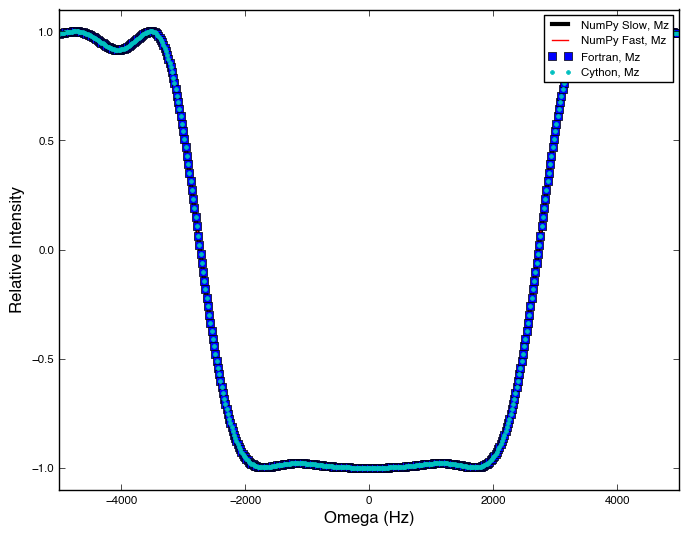

In [38]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax5 = plt.axes()
ax5.plot(relativeomega, xyzdata_numpyS[2], 'k', linewidth=3.0, label='NumPy Slow, Mz')
ax5.plot(relativeomega, xyzdata_numpyF[2], 'r', label='NumPy Fast, Mz')
ax5.plot(relativeomega, xyzdata_fortran[2], 'bs', label='Fortran, Mz')
ax5.plot(relativeomega ,xyzdata_cython[2], 'c.', label='Cython, Mz')
ax5.set_xlabel('Omega (Hz)')
ax5.set_ylabel('Relative Intensity')
ax5.set_xlim(offset)
ax5.set_ylim(-1.1, 1.1)
ax5.legend()

The result is an inversion of the magnetization from the *z*-axis for the frequency range of approximately -2000 to 2000 Hz. Note the inverted "top hat" shape referred to earlier in the post. This is exactly what is expected from a 180º pulse with the added benefit of bandwidth selectivity. Just outside of this range, the pulse does not fully invert the magnetization and the results can be unpredictable (see below). Further outside of the bandwidth limit, at around -4000 and 4000 Hz, the pulse has little effect on the magnetization. Again, exactly as expected.

The effect of the shaped pulse on the *x*- and *y*-components is quite different from that on the *z*-component, particularly near the limit of +/-2500 Hz for the inverted tophat.

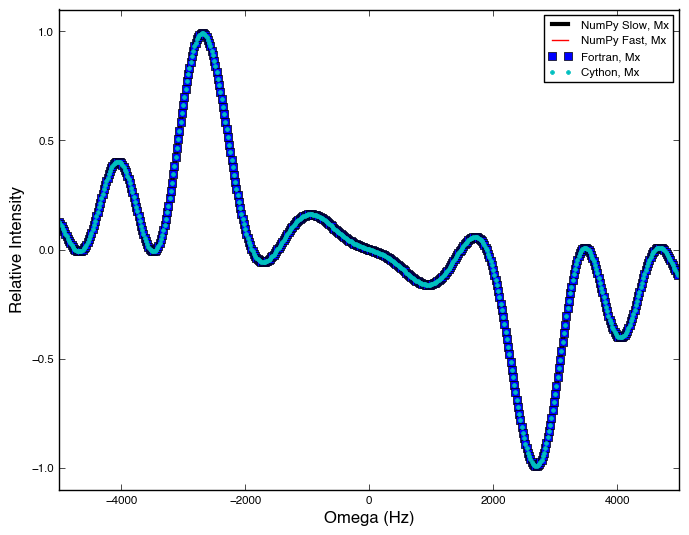

In [39]:
f = plt.figure()
f.set_facecolor((1.0, 1.0, 1.0, 1.0))
ax6 = plt.axes()
ax6.plot(relativeomega, xyzdata_numpyS[0], 'k', linewidth=3.0, label='NumPy Slow, Mx')
ax6.plot(relativeomega, xyzdata_numpyF[0], 'r', label='NumPy Fast, Mx')
ax6.plot(relativeomega, xyzdata_fortran[0], 'bs', label='Fortran, Mx')
ax6.plot(relativeomega, xyzdata_cython[0], 'c.', label='Cython, Mx')
ax6.set_xlabel('Omega (Hz)')
ax6.set_ylabel('Relative Intensity')
ax6.set_xlim(offset)
ax6.set_ylim(-1.1, 1.1)
ax6.legend()

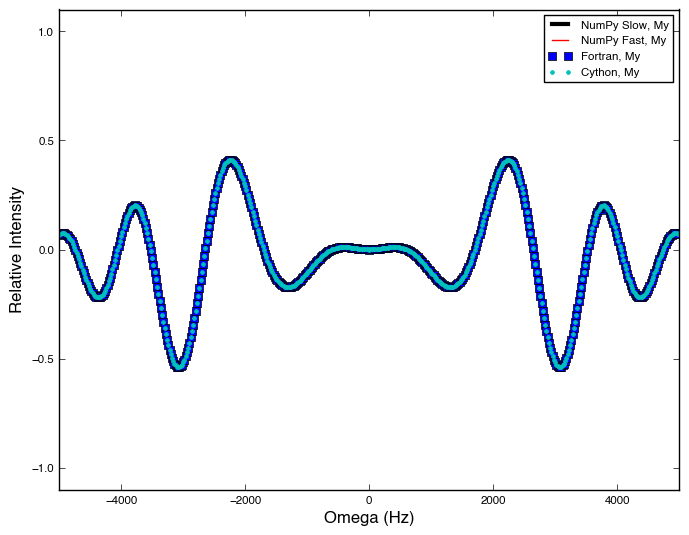

In [40]:
f = plt.figure()
f.set_facecolor((1.0,1.0,1.0,1.0))
ax7 = plt.axes()
ax7.plot(relativeomega, xyzdata_numpyS[1], 'k', linewidth=3.0, label='NumPy Slow, My')
ax7.plot(relativeomega, xyzdata_numpyF[1], 'r', label='NumPy Fast, My')
ax7.plot(relativeomega, xyzdata_fortran[1], 'bs', label='Fortran, My')
ax7.plot(relativeomega, xyzdata_cython[1], 'c.', label='Cython, My')
ax7.set_xlabel('Omega (Hz)')
ax7.set_ylabel('Relative Intensity')
ax7.set_xlim(offset)
ax7.set_ylim(-1.1, 1.1)
ax7.legend()